# Fitting wavelength with multiple sample-detector distances

Wavelength and detector distance are correlated parameters when fitting the geometry using a single detector position. One should fix either one, or the other.
The simultaneous fitting of several images taken at various detector distances has proven to alleviate this limitation (https://doi.org/10.1107/S1600577519013328).

This tutorial explains how to perform a multi-position geometry refinement, this within pyFAI using a notebook. 

The dataset was recorded at the DanMAX beamline at MaxIV (Lund, Sweden) and made available by Mads Ry Jørgensen. It represents LaB6 reference material collected at 20keV at with a Pilatus detector at various distances from the sample.

## Loading data

All the data are stored into a single HDF5 file following the Nexus convention. This file has been reprocessed and differs from what is acquired at the DanMAX beamline.

In [1]:
%pylab inline
import numpy
from matplotlib.pyplot import subplots
from pyFAI.goniometer import GeometryTransformation, ExtendedTransformation, SingleGeometry,\
                             GoniometerRefinement, Goniometer
from pyFAI.calibrant import get_calibrant
import h5py
import pyFAI
from pyFAI.gui import jupyter
import time
start_time = time.perf_counter()
import logging
logging.basicConfig(level=logging.WARNING)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Download data from internet

from silx.resources import ExternalResources

#Comment out and configure the proxy if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.company.com:3128"

downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/gonio/", "PYFAI_DATA")
data_file = downloader.getfile("LaB6_20keV.h5")

print("file downloaded:", data_file)

file downloaded: /tmp/pyFAI_testdata_kieffer/LaB6_20keV.h5


In [3]:
h5 = h5py.File(data_file)
images = h5["entry_0000/DanMAX/Pilatus/data"][()]
distances = h5["entry_0000/DanMAX/sdd/value"][()]
energy = h5["entry_0000/DanMAX/monochromator/energy"][()]
print("Distances: ", distances)
print("Energy:", energy)
LaB6 = get_calibrant("LaB6")
wavelength_guess = pyFAI.units.hc/energy*1e-10
print("Wavelength:", wavelength_guess)
LaB6.wavelength = wavelength_guess

Distances:  [174. 274. 374. 474. 574. 674.]
Energy: 20
Wavelength: 6.199209921660013e-11


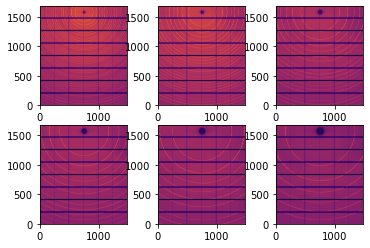

In [4]:
fig, ax = subplots(2,3)
for a,i in zip(ax.ravel(), images):
    jupyter.display(i, ax=a)

In [5]:
detector = pyFAI.detector_factory("Pilatus2MCdTe")
detector.mask = numpy.min(images, axis=0)<0

This dataset is composed of 6 images collected between 150 and 650 mm with a Pilatus 2M CdTe detector. Debye-Scherrer rings are very nicely visible and a fully automated calibration will be performed.

## Automatic calibration

Since those images are pretty nice, one can read the beam-center position at (x=749, y=1573, ). The tilt and other distortion will be neglected in this first stage. We will now perform the automatic ring extraction

In [6]:
geometries = {}
for dist, img  in zip(distances, images):
    ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(detector=detector, wavelength=wavelength_guess)
    ai.setFit2D(dist, 749, 1573)
    geo = SingleGeometry(dist, img, metadata=dist, calibrant=LaB6, detector=detector, geometry=ai)
    geometries[dist] = geo

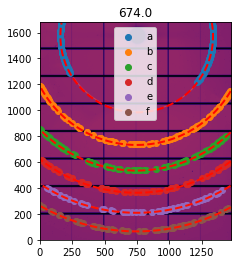

In [7]:
# Process the last image, the one with fewer rings: 

# First extract some control points:
geo.control_points  = geo.extract_cp()
# Visualization
ax = jupyter.display(sg=geo)

In [8]:
print("Optimization of the geometry ... residual error is:", geo.geometry_refinement.refine2())
print(geo.geometry_refinement)

Optimization of the geometry ... residual error is: 5.175870470359889e-09
Detector Pilatus CdTe 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 6.199210e-11m
SampleDetDist= 6.744688e-01m	PONI= 2.709195e-01, 1.308406e-01m	rot1=0.002840  rot2= 0.000654  rot3= -0.000000 rad
DirectBeamDist= 674.472mm	Center: x=749.565, y=1577.679 pix	Tilt=0.167 deg  tiltPlanRotation= 167.024 deg


Optimization of the geometry 174.0, residual error is: 5.068514020406129e-08


Optimization of the geometry 274.0, residual error is: 2.985455215759018e-08


Optimization of the geometry 374.0, residual error is: 1.6039670127416967e-08


Optimization of the geometry 474.0, residual error is: 1.0202095121132004e-08


Optimization of the geometry 574.0, residual error is: 7.76521357740184e-09


Optimization of the geometry 674.0, residual error is: 4.293229462137486e-09


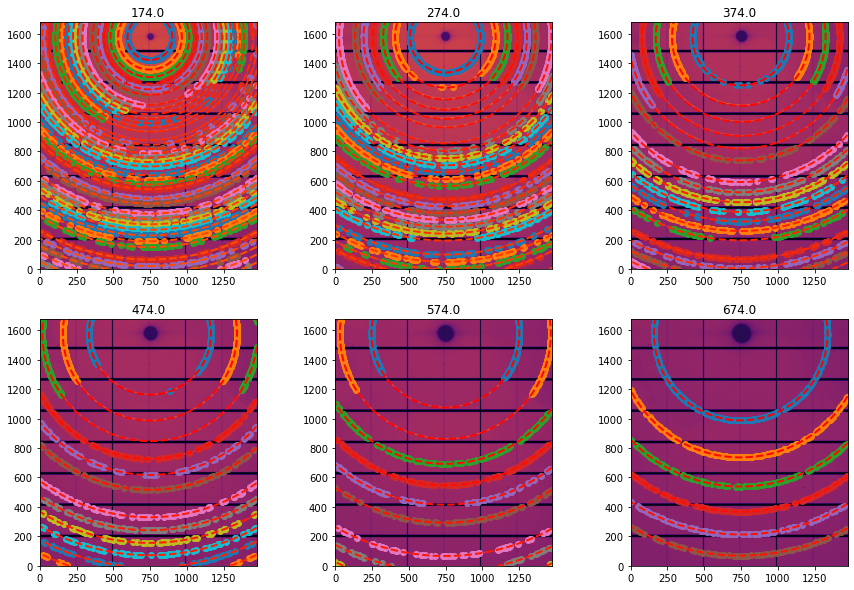

In [9]:
# Extraction of the control points for all geometries:
fig, ax = subplots(2,3, figsize=(15, 10))
for a, lbl in zip(ax.ravel(), geometries):
    geo = geometries[lbl]
    geo.control_points  = geo.extract_cp()
#     print(geo.control_points)
    print(f"Optimization of the geometry {lbl}, residual error is: {geo.geometry_refinement.refine2()}")
    jupyter.display(sg=geo, ax=a)
a.get_legend().remove()

At this stage, we have 6 images and between 38 and 6 rings per image which is enough to start calibrating them all-together.

## Sample stage setup

We will optimize the energy in addition to all other parameters except the rotation along the beam (rot3).

* `dist0` represents the offset of the sample-detector stage. The associated `scale0` is expected to be 1e-3 to convert milimeters in meters.
* `poni1` represents the vertical position of the center and the associated `scale1` is expected to be null.
* `poni2` represents the horizontal position of the center and the associated `scale2` is expected to be null.
* All other rotation are expected to be null as well.

In [10]:
goniotrans = ExtendedTransformation(param_names = ["dist0", "scale0", 
                                                   "poni1", "scale1",
                                                   "poni2", "scale2",
                                                   "rot1", "rot2", 
                                                   "energy"],
                                    dist_expr="dist0  + pos*scale0",
                                    poni1_expr="poni1 + pos*scale1",
                                    poni2_expr="poni2 + pos*scale2",
                                    rot1_expr="rot1",
                                    rot2_expr="rot2",
                                    rot3_expr="0",
                                    wavelength_expr="hc/energy*1e-10")


In [11]:
# Starting parameters ...

param = {"dist0":   0.0,
         "poni1":  geo.geometry_refinement.poni1,
         "poni2":  geo.geometry_refinement.poni2,
         "rot1":   0.0,
         "rot2":   0.0,
         "scale0": 0.001,
         "scale1": 0.0,
         "scale2": 0.0,
         "energy": energy,
        }

In [12]:
#Defines the bounds for some variables
bounds = {"dist0":  ( -0.1, 0.1),
          "poni1":  ( 0.0, 0.4),
          "poni2":  ( 0.0, 0.3),
          "rot1":   (-1.0, 1.0),
          "rot2":   (-1.0, 1.0),
          "scale0": (-1.1, 1.1),
          "scale1": (-1.1, 1.1),
          "scale2": (-1.1, 1.1),
          "energy": (energy-1,energy+1)
         }

In [13]:
def distance(param):
    """Since the label is directly the distance ..."""
    return float(param)
distance(152)

152.0

In [14]:
gonioref = GoniometerRefinement(param,         # Initial guess
                                bounds=bounds, # Enforces constrains
                                pos_function=distance,
                                trans_function=goniotrans,
                                detector=detector, 
                                wavelength=wavelength_guess)
print("Empty refinement object:", gonioref)
for lbl, geo in geometries.items():
    sg = gonioref.new_geometry(str(lbl), image=geo.image, metadata=lbl, control_points=geo.control_points, calibrant=LaB6)
    print(lbl, sg.get_position())
print("Populated refinement object:", gonioref)

Empty refinement object: GoniometerRefinement with 0 geometries labeled: .
174.0 174.0
274.0 274.0
374.0 374.0
474.0 474.0
574.0 574.0
674.0 674.0
Populated refinement object: GoniometerRefinement with 6 geometries labeled: 174.0, 274.0, 374.0, 474.0, 574.0, 674.0.


At this stage, the GoniometerRefinement is fully populated and can directly be optimzied:

 ## Optimization of all parameters (including the energy)
 
All optimizer available in scipy are exposed in pyFAI, the default one is `slsqp` which takes into account bounds and other constrains. It is very robust but not the most precise. This is why we finish with a `simplex` step (without bounds).

In [15]:
gonioref.refine2()

Cost function before refinement: 2.880916969921553e-05
[0.00000000e+00 1.00000000e-03 2.70885974e-01 0.00000000e+00
 1.30788706e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00000000e+01]
     fun: 5.118101156074647e-08
     jac: array([-8.97244086e-06, -2.84540380e-03,  7.10514885e-06,  4.16619455e-03,
       -1.47075184e-05, -3.20402490e-03,  3.65986947e-06,  4.65959376e-06,
        3.08546280e-07])
 message: 'Optimization terminated successfully'
    nfev: 253
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([-3.20409132e-04,  1.00165967e-03,  2.70548107e-01, -1.65205297e-06,
        1.28774484e-01,  2.14068503e-06,  1.96627753e-03,  2.97171604e-03,
        2.00000888e+01])
Cost function after refinement: 5.118101156074647e-08
GonioParam(dist0=-0.00032040913229132017, scale0=0.0010016596724372138, poni1=0.270548106509087, scale1=-1.6520529685497558e-06, poni2=0.12877448366736918, scale2=2.1406850310804572e-06, rot1=0.0019662775331658238, rot2=0.002971716042

array([-3.20409132e-04,  1.00165967e-03,  2.70548107e-01, -1.65205297e-06,
        1.28774484e-01,  2.14068503e-06,  1.96627753e-03,  2.97171604e-03,
        2.00000888e+01])

In [16]:
# The `simplex` provides a refinement without bonds but more percise
gonioref.refine2(method="simplex")

Cost function before refinement: 5.118101156074647e-08
[-3.20409132e-04  1.00165967e-03  2.70548107e-01 -1.65205297e-06
  1.28774484e-01  2.14068503e-06  1.96627753e-03  2.97171604e-03
  2.00000888e+01]
 final_simplex: (array([[-3.77494742e-04,  1.00280715e-03,  2.70526872e-01,
        -7.71433410e-07,  1.28778769e-01,  2.57758416e-06,
         2.35227029e-03,  2.30402796e-03,  2.00160238e+01],
       [-3.77494742e-04,  1.00280715e-03,  2.70526872e-01,
        -7.71433410e-07,  1.28778769e-01,  2.57758416e-06,
         2.35227029e-03,  2.30402796e-03,  2.00160238e+01],
       [-3.77494742e-04,  1.00280715e-03,  2.70526872e-01,
        -7.71433410e-07,  1.28778769e-01,  2.57758416e-06,
         2.35227029e-03,  2.30402796e-03,  2.00160238e+01],
       [-3.77494742e-04,  1.00280715e-03,  2.70526872e-01,
        -7.71433410e-07,  1.28778769e-01,  2.57758416e-06,
         2.35227029e-03,  2.30402796e-03,  2.00160238e+01],
       [-3.77494742e-04,  1.00280715e-03,  2.70526872e-01,
        -

array([-3.77494742e-04,  1.00280715e-03,  2.70526872e-01, -7.71433410e-07,
        1.28778769e-01,  2.57758416e-06,  2.35227029e-03,  2.30402796e-03,
        2.00160238e+01])

In [17]:
gonioref.save("table.json")

In [18]:
print(open("table.json").read())

{
  "content": "Goniometer calibration v2",
  "detector": "Pilatus CdTe 2M",
  "detector_config": {},
  "wavelength": 6.194247151715292e-11,
  "param": [
    -0.0003774947419198434,
    0.0010028071468837774,
    0.2705268717310978,
    -7.714334097724575e-07,
    0.12877876885464118,
    2.577584156203786e-06,
    0.002352270294048905,
    0.0023040279584365785,
    20.01602380345236
  ],
  "param_names": [
    "dist0",
    "scale0",
    "poni1",
    "scale1",
    "poni2",
    "scale2",
    "rot1",
    "rot2",
    "energy"
  ],
  "pos_names": [
    "pos"
  ],
  "trans_function": {
    "content": "ExtendedTransformation",
    "param_names": [
      "dist0",
      "scale0",
      "poni1",
      "scale1",
      "poni2",
      "scale2",
      "rot1",
      "rot2",
      "energy"
    ],
    "pos_names": [
      "pos"
    ],
    "dist_expr": "dist0  + pos*scale0",
    "poni1_expr": "poni1 + pos*scale1",
    "poni2_expr": "poni2 + pos*scale2",
    "rot1_expr": "rot1",
    "rot2_expr": "rot2"

In [19]:
gonioref.wavelength, gonioref._wavelength

(6.194247151715292e-11, 6.199209921660013e-11)

In [20]:
print("Ensure calibrant's wavelength has been updated:")
LaB6

Ensure calibrant's wavelength has been updated:


LaB6 Calibrant with 152 reflections at wavelength 6.194247151715397e-11

In [21]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}s")

Total execution time: 36.381s


This method ensures  the wavelength has been updated in all objects important for the calibration.

At this stage, calibration has been performed on a set of points extracted automatically. Each individual image should be controled to ensure control points are homogeneously distributed along the ring. If not, those images should see their control-points re-extracted (starting from the latest/best model) and refined again.
Basically, this comes down to running cells 8 and after again.

## Conclusions

* When the dataset is "clean", auto-extraction of control points works out of the box 
* Multi-position calibration to be performed in a minute once the model is known
* Energy can be refined with this methodology.